## Performance Analysis of Regression FNN on engineered features

- **Train the regression models on muons only**  
- **Test on testing portion of muons and all pions**  
- **No selection on momentum range**  
- **Only the in-time hits where delta <= 0.5 are included**

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyarrow as pa
import polars as pl
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import tqdm
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import mean_std_cross_val_scores

- **Regressors (Engineered features used for the models):**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points  

- **Target:**
    - `ring_radius_cal`: calculated ring radius based on the particle mass and track momentum

### 1.0 Read and process data

In [2]:
event_with_hit_features_path = 'data/events_with_hit_features_[cut_off_time=0.5].parquet'

In [3]:
df = pd.read_parquet(event_with_hit_features_path
                    ).dropna()

In [4]:
df.shape

(2374282, 42)

In [5]:
df['label'].value_counts()

0    2158635
1     215647
Name: label, dtype: int64

In [6]:
df_muons = df.query('label==0')

In [7]:
df_muons.shape

(2158635, 42)

In [8]:
df_muons.describe()

,composite_event_id,total_in_time_hits,x_aligned_min,x_aligned_max,x_aligned_width,y_aligned_min,y_aligned_max,y_aligned_width,hit_distance_min,hit_distance_max,...,ring_likelihood_muon,ring_likelihood_positron,ring_likelihood_kaon,ring_likelihood_background,label,first_hit,last_hit,total_hits,mass,ring_radius_cal
count,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,...,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2158635.0,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06
mean,1.026082e+15,1.714035e+01,-1.929751e+02,1.432334e+02,3.362086e+02,-1.868689e+02,1.581942e+02,3.450631e+02,1.507970e+02,2.195136e+02,...,8.887756e-01,1.661901e-01,4.455240e-04,5.526685e-03,0.0,4.410481e+07,4.410485e+07,4.148737e+01,1.056601e+02,1.805167e+02
std,9.001261e+14,5.754839e+00,3.468840e+01,5.513756e+01,6.401603e+01,3.742609e+01,4.615988e+01,6.021390e+01,2.241440e+01,2.931807e+01,...,2.620142e-01,3.180548e-01,2.039895e-02,7.398906e-02,0.0,2.602615e+07,2.602615e+07,2.274315e+01,0.000000e+00,1.145780e+01
min,1.285739e+12,3.000000e+00,-4.992225e+02,-2.845825e+02,4.899994e+00,-5.044576e+02,-3.803433e+02,5.279999e+00,4.684291e-01,4.993096e+01,...,1.216099e-37,1.216099e-37,1.216099e-37,1.216099e-37,0.0,0.000000e+00,2.000000e+01,5.000000e+00,1.056600e+02,8.215014e+00
25%,4.125031e+14,1.300000e+01,-2.108451e+02,1.165552e+02,3.060000e+02,-2.084747e+02,1.499109e+02,3.273500e+02,1.428338e+02,2.079562e+02,...,1.000000e+00,4.831920e-09,1.216099e-37,1.216099e-37,0.0,2.120522e+07,2.120530e+07,2.400000e+01,1.056600e+02,1.795201e+02
50%,8.336160e+14,1.700000e+01,-1.970281e+02,1.648931e+02,3.510000e+02,-1.930785e+02,1.738190e+02,3.585400e+02,1.533740e+02,2.181407e+02,...,1.000000e+00,1.002324e-03,1.216099e-37,1.216099e-37,0.0,4.387733e+07,4.387735e+07,3.700000e+01,1.056600e+02,1.840819e+02
75%,1.344889e+15,2.100000e+01,-1.808926e+02,1.813009e+02,3.780000e+02,-1.757001e+02,1.832392e+02,3.897100e+02,1.641873e+02,2.266251e+02,...,1.000000e+00,1.290363e-01,1.216099e-37,1.216099e-37,0.0,6.662182e+07,6.662186e+07,5.400000e+01,1.056600e+02,1.865573e+02
max,2.117348e+16,6.700000e+01,3.411062e+02,4.694849e+02,6.439000e+02,3.020579e+02,4.617254e+02,6.026600e+02,4.044119e+02,5.522397e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,8.962015e+07,8.962017e+07,3.790000e+02,1.056600e+02,1.890351e+02


In [9]:
train_df, test_df_muon = train_test_split(df_muons, 
                                          random_state=42)

In [10]:
test_df = pd.concat([test_df_muon, df.query('label==1')])

In [11]:
X_train_raw = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test_raw = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']

In [12]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

### 2.0 Train with Fully Connected Regression NN

In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().flatten(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.float32)

In [14]:
trainset = TensorDataset(X_train, y_train)

In [15]:
# split trainset to train and validation
train_size = int(0.6 * len(trainset)) # 60% of train data
val_size = len(trainset) - train_size

generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=trainset, 
                                  lengths=[train_size, val_size],
                                  generator=generator1)

In [16]:
BATCH_SIZE = 1000 # adjust batch size later
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [18]:
# below code adopted from MDS DSCI 572 Lecture 5 notes
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
            
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = criterion(y_hat, y_valid)  # Calculate loss based on output

                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_loss, valid_loss

In [19]:
# Define the model
model = torch.nn.Sequential(
    nn.Linear(18, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)
model.to(device)

Sequential(
  (0): Linear(in_features=18, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=12, bias=True)
  (9): ReLU()
  (10): Linear(in_features=12, out_features=1, bias=True)
)

In [20]:
# print(model)

In [21]:
# summary(model)

In [22]:
# model.state_dict()

In [23]:
LEARNING_RATE = 0.0001
criterion = nn.MSELoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
%%time
train_loss, valid_loss = trainer(model, 
                                 criterion, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=30, 
                                 patience=5,
                                 verbose=True)

Epoch   1: Train Loss: 5071.575. Valid Loss: 58.353.
Epoch   2: Train Loss: 23.398. Valid Loss: 14.579.
Epoch   3: Train Loss: 12.700. Valid Loss: 11.524.
Epoch   4: Train Loss: 10.771. Valid Loss: 10.362.
Epoch   5: Train Loss: 10.060. Valid Loss: 9.793.
Epoch   6: Train Loss: 9.580. Valid Loss: 9.392.
Epoch   7: Train Loss: 9.250. Valid Loss: 9.249.
Epoch   8: Train Loss: 8.978. Valid Loss: 9.624.
Epoch   9: Train Loss: 8.761. Valid Loss: 8.889.
Epoch  10: Train Loss: 8.607. Valid Loss: 8.681.
Epoch  11: Train Loss: 8.437. Valid Loss: 9.291.
Epoch  12: Train Loss: 8.316. Valid Loss: 8.547.
Epoch  13: Train Loss: 8.209. Valid Loss: 9.061.
Epoch  14: Train Loss: 8.103. Valid Loss: 8.344.
Epoch  15: Train Loss: 8.030. Valid Loss: 8.473.
Epoch  16: Train Loss: 8.002. Valid Loss: 8.228.
Epoch  17: Train Loss: 7.895. Valid Loss: 8.232.
Epoch  18: Train Loss: 7.824. Valid Loss: 8.415.
Epoch  19: Train Loss: 7.772. Valid Loss: 8.396.
Epoch  20: Train Loss: 7.707. Valid Loss: 8.222.
Epoch  21

### 3.0 Prediction performance on test df

In [25]:
test_result_nn = test_df.copy()

In [26]:
# drop irrelevant cols to reduce size of file
test_result_nn = test_result_nn.drop(['run_id','burst_id','event_id','track_id',
                                      'chod_time','track_pos_x','track_pos_y',
                                      'ring_centre_pos_x','ring_centre_pos_y',
                                      'ring_likelihood_pion','ring_likelihood_muon','ring_likelihood_positron',
                                      'ring_likelihood_kaon','ring_likelihood_background',
                                      'first_hit','last_hit','total_hits','mass'], axis=1)

In [27]:
# notice that tensor on mps cannot be converted to numpy directly so using to('cpu')
test_result_nn['ring_radius_pred'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

In [28]:
r2_score(y_test, test_result_nn['ring_radius_pred'])

0.9333767305496504

In [29]:
mean_absolute_error(y_test, test_result_nn['ring_radius_pred'])

1.921123

### 4.0 Prediction resolution analysis

#### 4.1 Distribution of predicted radius of pions and muons in each momentum bin

In [30]:
test_result_nn['track_momentum'].describe()

count    755306.000000
mean         36.143753
std          12.013361
min           9.442538
25%          27.424381
50%          35.071695
75%          43.918932
max          74.378830
Name: track_momentum, dtype: float64

In [31]:
bins = np.arange(9, 76, 1)
test_result_nn['momentum_bin'] = pd.cut(test_result_nn['track_momentum'], bins=bins)

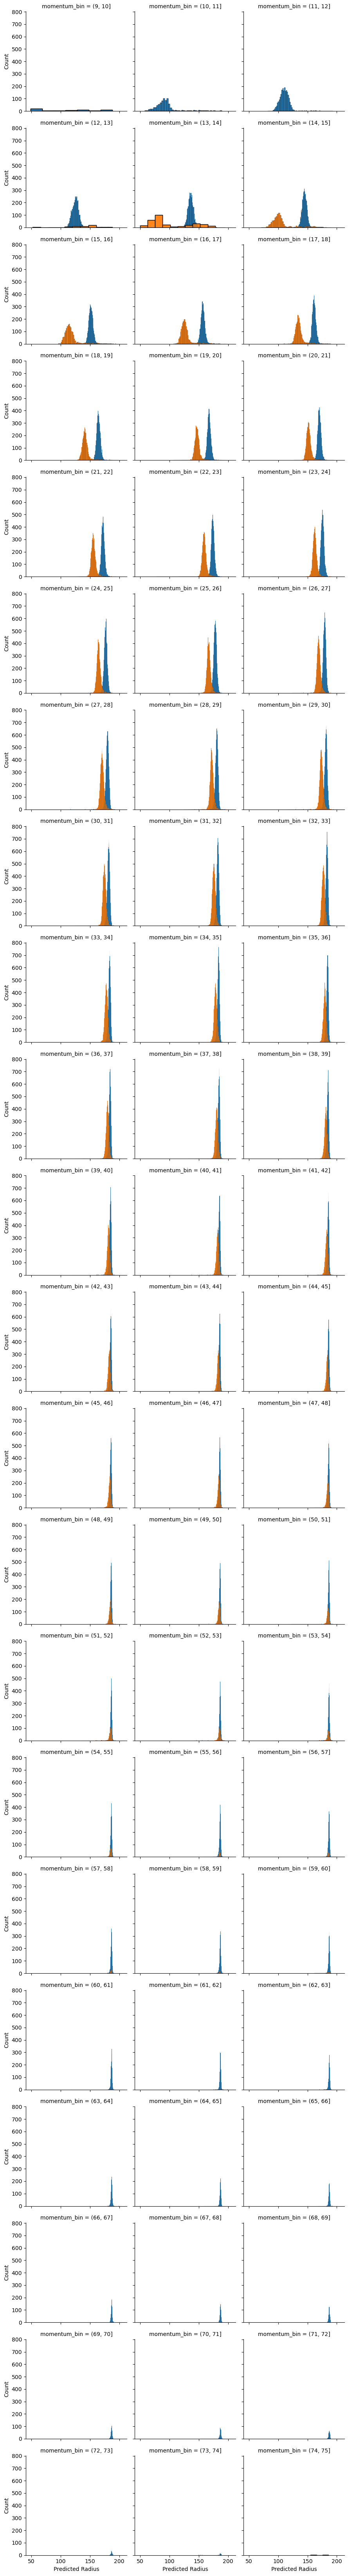

In [32]:
# from scipy.stats import scoreatpercentile

g = sns.FacetGrid(test_result_nn, col='momentum_bin', col_wrap=3, hue='class')
g.map(sns.histplot, 'ring_radius_pred', fill=True)
g.map(sns.histplot, 'ring_radius_pred', lw=1)

g.set_axis_labels('Predicted Radius', 'Count')

plt.tight_layout()

plt.show()

**Stat of predicted radius of pions and muons in each momentum bin**

In [62]:
stat_pred_nn = pd.DataFrame(test_result_nn.groupby(['momentum_bin', 'class']).aggregate({'ring_radius_pred': ['mean', 'std','min','max']}))
stat_pred_nn = stat_pred_nn.dropna()
stat_pred_nn = stat_pred_nn.reset_index()
stat_pred_nn.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

In [64]:
stat_cal = pd.DataFrame(test_result_nn.groupby(['momentum_bin', 'class']).aggregate({'ring_radius_cal': ['mean', 'std','min','max']}))
stat_cal = stat_cal.dropna()
stat_cal = stat_cal.reset_index()
stat_cal.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

In [165]:
stat_pred_nn

,momentum_bin,class,mean,std,min,max
0,"(9, 10]",muon,108.147797,46.548619,48.265717,188.381210
1,"(10, 11]",muon,94.178116,20.742524,58.018078,189.410782
2,"(11, 12]",muon,111.212479,10.756984,82.724663,192.919434
3,"(12, 13]",muon,125.842178,7.799744,78.962860,188.502502
4,"(12, 13]",pion,137.351913,30.899627,52.145508,188.105408
...,...,...,...,...,...,...
111,"(70, 71]",muon,186.978821,1.703210,153.397812,191.918655
112,"(71, 72]",muon,187.064392,1.141874,183.135147,190.361755
113,"(72, 73]",muon,187.081039,1.095454,183.507126,190.497299
114,"(73, 74]",muon,184.694550,8.658333,149.773880,188.644363


In [66]:
stat_cal

,momentum_bin,class,mean,std,min,max
0,"(9, 10]",muon,49.861061,13.243354,10.650927,63.483513
1,"(10, 11]",muon,87.741951,8.538834,63.569767,98.122978
2,"(11, 12]",muon,109.775749,5.562169,98.169144,117.865524
3,"(12, 13]",muon,125.189880,3.792149,117.892784,131.172287
4,"(12, 13]",pion,37.966068,13.986021,4.270976,54.305653
...,...,...,...,...,...,...
111,"(70, 71]",muon,188.810883,0.014358,188.788422,188.837021
112,"(71, 72]",muon,188.859543,0.013556,188.837097,188.883606
113,"(72, 73]",muon,188.904037,0.012368,188.883881,188.928314
114,"(73, 74]",muon,188.942963,0.011213,188.928772,188.971512


Text(0.5, 1.0, 'Stat of muons in each momentum bin (bin size = 1)')

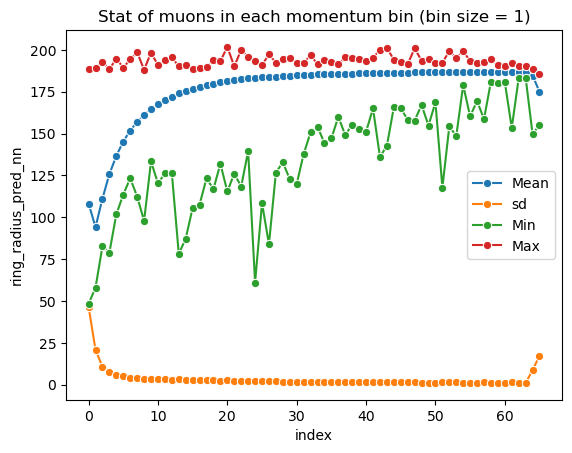

In [167]:
stat_pred_nn_muon = stat_pred_nn.query('`class`=="muon"').reset_index()

sns.lineplot(data=stat_pred_nn_muon, x=stat_pred_nn_muon.index, y='mean',label='Mean',marker='o')
sns.lineplot(data=stat_pred_nn_muon, x=stat_pred_nn_muon.index, y='std', label='sd',marker='o')
sns.lineplot(data=stat_pred_nn_muon, x=stat_pred_nn_muon.index, y='min', label='Min',marker='o')
sns.lineplot(data=stat_pred_nn_muon, x=stat_pred_nn_muon.index, y='max', label='Max',marker='o')


plt.ylabel('ring_radius_pred_nn')
plt.xlabel('index')
plt.title('Stat of muons in each momentum bin (bin size = 1)')

Text(0.5, 1.0, 'Stat of pions in each momentum bin (bin size = 1)')

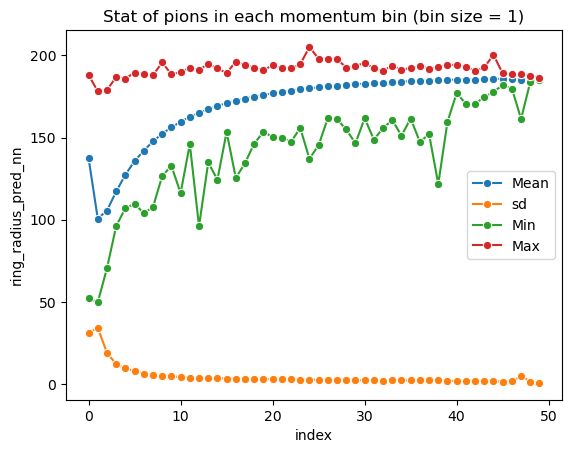

In [118]:
stat_pred_nn_pion = stat_pred_nn.query('`class`=="pion"').reset_index()

sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='mean',label='Mean',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='std', label='sd',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='min', label='Min',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='max', label='Max',marker='o')


plt.ylabel('ring_radius_pred_nn')
plt.xlabel('index')
plt.title('Stat of pions in each momentum bin (bin size = 1)')

Text(0.5, 1.0, 'Stat of muons in each momentum bin (bin size = 1)')

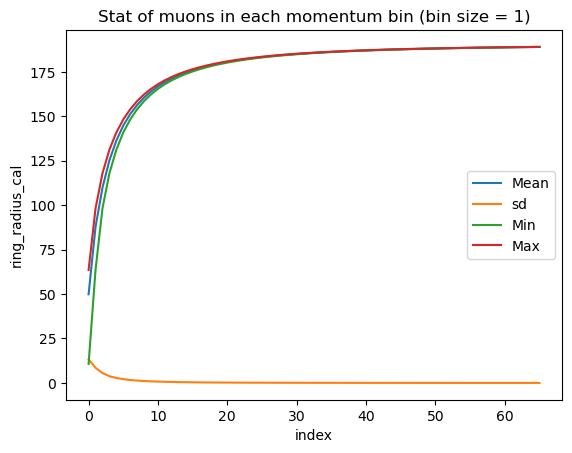

In [86]:
stat_cal_muon = stat_cal.query('`class`=="muon"').reset_index()

sns.lineplot(data=stat_cal_muon, x=stat_cal_muon.index, y='mean',label='Mean')
sns.lineplot(data=stat_cal_muon, x=stat_cal_muon.index, y='std', label='sd')
sns.lineplot(data=stat_cal_muon, x=stat_cal_muon.index, y='min', label='Min')
sns.lineplot(data=stat_cal_muon, x=stat_cal_muon.index, y='max', label='Max')


plt.ylabel('ring_radius_cal')
plt.xlabel('index')
plt.title('Stat of muons in each momentum bin (bin size = 1)')

Text(0.5, 1.0, 'Stat of pions in each momentum bin (bin size = 1)')

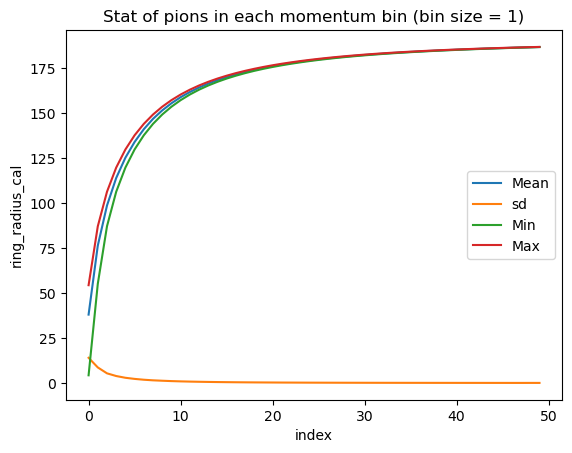

In [85]:
stat_cal_pion = stat_cal.query('`class`=="pion"').reset_index()

sns.lineplot(data=stat_cal_pion, x=stat_cal_pion.index, y='mean',label='Mean')
sns.lineplot(data=stat_cal_pion, x=stat_cal_pion.index, y='std', label='sd')
sns.lineplot(data=stat_cal_pion, x=stat_cal_pion.index, y='min', label='Min')
sns.lineplot(data=stat_cal_pion, x=stat_cal_pion.index, y='max', label='Max')


plt.ylabel('ring_radius_cal')
plt.xlabel('index')
plt.title('Stat of pions in each momentum bin (bin size = 1)')

In [158]:
# filter ring_radius since SOTA has outliers
sota = test_result_nn.query('ring_radius <= 200')

stat_pred_sota = pd.DataFrame(sota.groupby(['momentum_bin', 'class']).aggregate({'ring_radius': ['mean', 'std','min','max']}))
stat_pred_sota = stat_pred_sota.dropna()
stat_pred_sota = stat_pred_sota.reset_index()
stat_pred_sota.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

Text(0.5, 1.0, 'Stat of muons in each momentum bin (bin size = 1)')

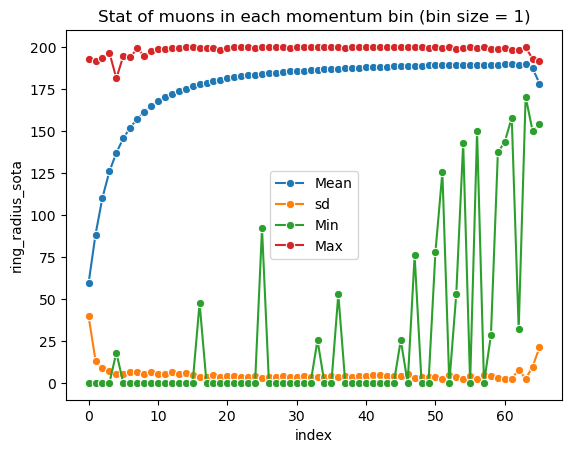

In [159]:
stat_pred_sota_muon = stat_pred_sota.query('`class`=="muon"').reset_index()

sns.lineplot(data=stat_pred_sota_muon, x=stat_pred_sota_muon.index, y='mean',label='Mean',marker='o')
sns.lineplot(data=stat_pred_sota_muon, x=stat_pred_sota_muon.index, y='std', label='sd',marker='o')
sns.lineplot(data=stat_pred_sota_muon, x=stat_pred_sota_muon.index, y='min', label='Min',marker='o')
sns.lineplot(data=stat_pred_sota_muon, x=stat_pred_sota_muon.index, y='max', label='Max',marker='o')


plt.ylabel('ring_radius_sota')
plt.xlabel('index')
plt.title('Stat of muons in each momentum bin (bin size = 1)')

Text(0.5, 1.0, 'Stat of pions in each momentum bin (bin size = 1)')

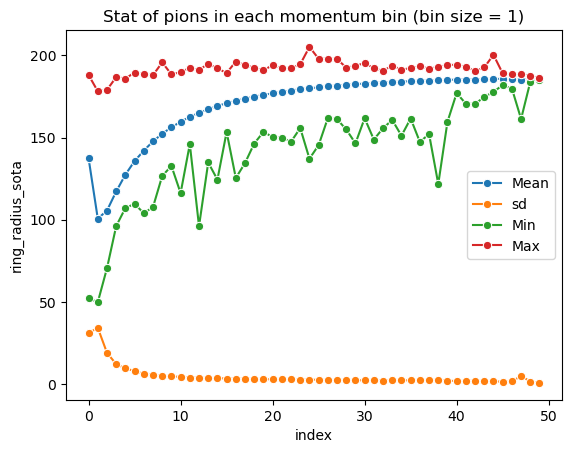

In [160]:
stat_pred_sota_pion = stat_pred_sota.query('`class`=="pion"').reset_index()

sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='mean',label='Mean',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='std', label='sd',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='min', label='Min',marker='o')
sns.lineplot(data=stat_pred_nn_pion, x=stat_pred_nn_pion.index, y='max', label='Max',marker='o')


plt.ylabel('ring_radius_sota')
plt.xlabel('index')
plt.title('Stat of pions in each momentum bin (bin size = 1)')

#### 4.2 Calculate the resolution (2.5% quantile of muons - 97.5% of pions)

In [139]:
momentum_bins = test_result_nn['momentum_bin'].unique()

quantiles_975_pion = []
quantiles_025_muon = []
differences = []

for momentum_bin in momentum_bins:
    filtered_df = test_result_nn[test_result_nn['momentum_bin'] == momentum_bin]
    grouped_df = filtered_df.groupby('class')

    quantile_975_pion = grouped_df['ring_radius_pred'].quantile(0.975).get('pion')
    quantile_025_muon = grouped_df['ring_radius_pred'].quantile(0.025).get('muon')
    
    if quantile_975_pion is None:
        quantile_975_pion = np.nan

    if quantile_025_muon is None:
        quantile_025_muon = np.nan

    difference = quantile_025_muon - quantile_975_pion
        
    quantiles_975_pion.append(quantile_975_pion)
    quantiles_025_muon.append(quantile_025_muon)
    differences.append(difference)

# Create a dataframe to store the quantiles and differences
resolution_df_nn = pd.DataFrame({'momentum_bins': momentum_bins, 
                              'quantile_975_pion': quantiles_975_pion,
                              'quantile_025_muon': quantiles_025_muon,
                              'differences': differences
                             })    
resolution_df_nn = resolution_df_nn.sort_values(by='momentum_bins').reset_index(drop=True)

resolution_df_nn

,momentum_bins,quantile_975_pion,quantile_025_muon,differences
0,"(9, 10]",NaN,49.613713,NaN
1,"(10, 11]",NaN,66.733127,NaN
2,"(11, 12]",NaN,95.976482,NaN
3,"(12, 13]",184.289677,114.454788,-69.834889
4,"(13, 14]",169.407297,127.402275,-42.005022
...,...,...,...,...
61,"(70, 71]",NaN,184.366617,NaN
62,"(71, 72]",NaN,184.621671,NaN
63,"(72, 73]",NaN,184.739334,NaN
64,"(73, 74]",NaN,152.819513,NaN


Text(0.5, 1.0, 'Difference between q=0.025 muons & q=0.975 pions in each momentum bin (bin size = 1)')

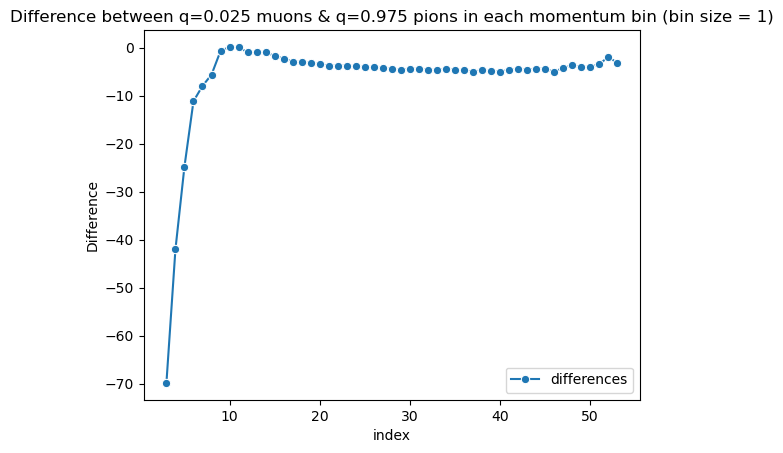

In [151]:
sns.lineplot(data=resolution_df_nn, x=resolution_df_nn.index, y='differences',label='differences',marker='o')

plt.ylabel('Difference')
plt.xlabel('index')
plt.title('Difference between q=0.025 muons & q=0.975 pions in each momentum bin (bin size = 1)')

**Manually verify differences calculation**

In [147]:
mon_39_40_pion = test_result_nn[(test_result_nn['class']=='pion')&(test_result_nn['momentum_bin']==pd.Interval(39, 40))]
mon_39_40_muon = test_result_nn[(test_result_nn['class']=='muon')&(test_result_nn['momentum_bin']==pd.Interval(39, 40))]

In [148]:
mon_39_40_muon['ring_radius_pred'].quantile(q=0.025)

181.33057022094727

In [149]:
mon_39_40_pion['ring_radius_pred'].quantile(q=0.975)

185.69829559326172

#### 4.3 FPRs of muons when fixing q=0.975 of pions in each momentum bin

In [109]:
momentum_bins = test_result_nn['momentum_bin'].unique()

decision_boundaries_nn = []
fprs_nn = []

for momentum_bin in momentum_bins:
    filtered_df = test_result_nn[test_result_nn['momentum_bin'] == momentum_bin]
    grouped_df = filtered_df.groupby('class')

    quantile_975 = grouped_df['ring_radius_pred'].quantile(0.975)
    decision_boundary = quantile_975.get('pion')

    if decision_boundary is None:
        decision_boundary = np.nan

    decision_boundaries_nn.append(decision_boundary)
    
    filtered_muons = filtered_df[(filtered_df['class'] == 'muon') & (filtered_df['ring_radius_pred'] < decision_boundary)]
    fpr = filtered_muons.shape[0] / filtered_df[filtered_df['class'] == 'muon'].shape[0]

    fprs_nn.append(fpr)

fpr_df_nn = pd.DataFrame({'momentum_bin': momentum_bins, 'decision_boundaries_nn': decision_boundaries_nn, 'fprs_nn': fprs_nn})

In [110]:
fpr_df_nn = fpr_df_nn.sort_values(by='momentum_bin').reset_index(drop=True)
fpr_df_nn

,momentum_bin,decision_boundaries_nn,fprs_nn
0,"(9, 10]",NaN,0.000000
1,"(10, 11]",NaN,0.000000
2,"(11, 12]",NaN,0.000000
3,"(12, 13]",184.289677,0.999074
4,"(13, 14]",169.407297,0.995051
...,...,...,...
61,"(70, 71]",NaN,0.000000
62,"(71, 72]",NaN,0.000000
63,"(72, 73]",NaN,0.000000
64,"(73, 74]",NaN,0.000000


**Compare with SOTA**

In [111]:
decision_boundaries_sota = []
fprs_sota = []

for momentum_bin in momentum_bins:
    filtered_df = test_result_nn[test_result_nn['momentum_bin'] == momentum_bin]
    grouped_df = filtered_df.groupby('class')

    quantile_975 = grouped_df['ring_radius'].quantile(0.975)
    decision_boundary = quantile_975.get('pion')

    if decision_boundary is None:
        decision_boundary = np.nan

    decision_boundaries_sota.append(decision_boundary)
    
    filtered_muons = filtered_df[(filtered_df['class'] == 'muon') & (filtered_df['ring_radius'] < decision_boundary)]
    fpr = filtered_muons.shape[0] / filtered_df[filtered_df['class'] == 'muon'].shape[0]

    fprs_sota.append(fpr)

fpr_df_sota = pd.DataFrame({'momentum_bin': momentum_bins, 'decision_boundaries_sota': decision_boundaries_sota, 'fprs_sota': fprs_sota})

In [112]:
fpr_df_sota = fpr_df_sota.sort_values(by='momentum_bin').reset_index(drop=True)
fpr_df_sota

,momentum_bin,decision_boundaries_sota,fprs_sota
0,"(9, 10]",NaN,0.000000
1,"(10, 11]",NaN,0.000000
2,"(11, 12]",NaN,0.000000
3,"(12, 13]",999999.000000,0.994444
4,"(13, 14]",188.095831,0.993566
...,...,...,...
61,"(70, 71]",NaN,0.000000
62,"(71, 72]",NaN,0.000000
63,"(72, 73]",NaN,0.000000
64,"(73, 74]",NaN,0.000000


Text(0.5, 1.0, 'FPRs of muons when fixing q=0.975 of pions in each momentum bin (bin size = 1)')

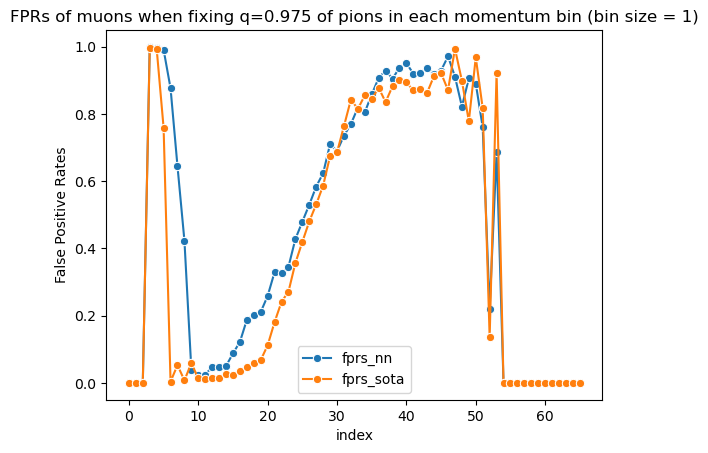

In [121]:
sns.lineplot(data=fpr_df_nn, x=fpr_df_nn.index, y='fprs_nn',label='fprs_nn',marker='o')
sns.lineplot(data=fpr_df_sota, x=fpr_df_sota.index, y='fprs_sota',label='fprs_sota',marker='o')

plt.ylabel('False Positive Rates')
plt.xlabel('index')
plt.title('FPRs of muons when fixing q=0.975 of pions in each momentum bin (bin size = 1)')

#### 4.4 Muons FPR vs. quantiles in each momentum bin for FNN and SOTA

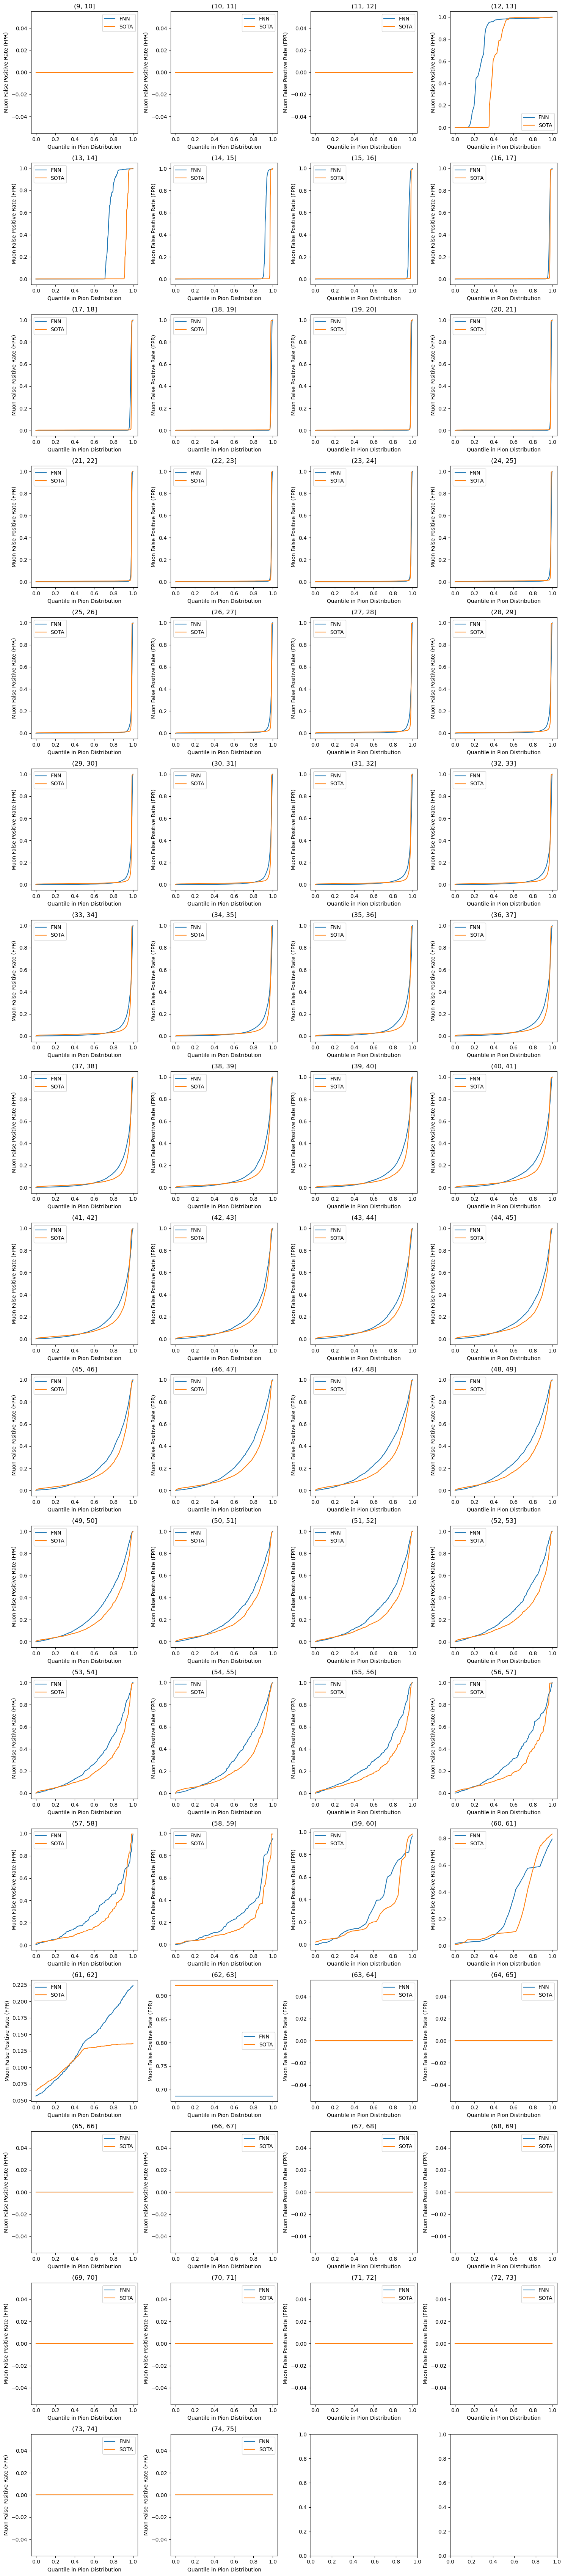

In [124]:
# Get unique momentum_bin values
momentum_bins = test_result_nn['momentum_bin'].sort_values().unique()

# Calculate the number of rows and columns for subplots
num_rows = (len(momentum_bins) + 3) // 4
num_cols = min(len(momentum_bins), 4)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Flatten the axes array if necessary
axes = axes.flatten()

# Loop over each momentum_bin
for i, momentum_bin in enumerate(momentum_bins):
    # Filter the dataframe for the current momentum_bin
    filtered_df = test_result_nn[test_result_nn['momentum_bin'] == momentum_bin]

    # Filter the dataframe for 'muons' and 'pions'
    filtered_muons = filtered_df[filtered_df['class'] == 'muon']
    filtered_pions = filtered_df[filtered_df['class'] == 'pion']

    # Calculate the quantiles from the Pion distribution for 'radius_pred' column
    quantiles = np.linspace(0, 1, num=400)
    decision_boundaries_nn = filtered_pions['ring_radius_pred'].quantile(quantiles)
    decision_boundaries_sota = filtered_pions['ring_radius'].quantile(quantiles)

    # Calculate the false positive rate (FPR) for each quantile value based on 'radius_pred' column
    fprs_pred = []
    for decision_boundary in decision_boundaries_nn:
        filtered_below_boundary = filtered_muons[filtered_muons['ring_radius_pred'] < decision_boundary]
        fpr_pred = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_pred.append(fpr_pred)

    # Calculate the false positive rate (FPR) for each quantile value based on 'ring_radius' column
    fprs_ring = []
    for decision_boundary in decision_boundaries_sota:
        filtered_below_boundary = filtered_muons[filtered_muons['ring_radius'] < decision_boundary]
        fpr_ring = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_ring.append(fpr_ring)

    # Create a dataframe to store the quantiles and FPRs for 'radius_pred' column
    data_pred = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (ring_radius_pred)': fprs_pred})

    # Create a dataframe to store the quantiles and FPRs for 'ring_radius' column
    data_ring = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (ring_radius)': fprs_ring})

    # Create a new subplot for the current momentum_bin
    ax = axes[i]
    sns.lineplot(data=data_pred, x='Quantile', y='Muon FPR (ring_radius_pred)', ax=ax, label='FNN')
    sns.lineplot(data=data_ring, x='Quantile', y='Muon FPR (ring_radius)', ax=ax, label='SOTA')
    ax.set_xlabel('Quantile in Pion Distribution')
    ax.set_ylabel('Muon False Positive Rate (FPR)')
    ax.set_title(f'{momentum_bin}')
    ax.legend()

# Adjust the subplot layout
plt.tight_layout()

# Show the plots
plt.show()

### Plot the distributions of predicted radii in pions and muons in each momentum bin (SOTA)

In [ ]:
# sota = test_result_nn.query('ring_radius <= 200')

In [ ]:
# g = sns.FacetGrid(sota, col='momentum_bin', col_wrap=3, hue='class')
# g.map(sns.histplot, 'ring_radius', fill=True)
# g.map(sns.histplot, 'ring_radius', lw=1)

# g.set_axis_labels('SOTA Radius', 'Count')

# plt.tight_layout()

# plt.show()